# Домашнее задание

Работа с Vision моделями

**Цель:**

Закрепить навыки работы с Vision- моделями в задачах визуального вопросно-ответного моделирования (VQA) на русском языке. 

Научиться:
- загружать датасеты с HuggingFace;
- использовать мультимодальные LLM, работающие с изображениями и русским языком;
- формировать промпты;
- оценивать качество предсказаний;
- анализировать влияние промпта на результат.

## 1. Загрузка и подготовка данных

Выберите один из русскоязычных VQA-датасетов:

- ruVQA
- ruCLEVR

• Загрузите датасет через datasets из HuggingFace.

• Возьмите сэмпл 100–200 примеров из тестовой части, стараясь сбалансировать его по целевым классам.

• Выведите несколько примеров с изображением, вопросом и правильным ответом.

In [4]:
from PIL import Image
from tqdm.auto import tqdm
import io, gc
import random
import requests 
import numpy as np
import pandas as pd
import torch

from datasets import load_dataset

from transformers import AutoProcessor, AutoTokenizer, AutoModelForVision2Seq, Qwen2VLForConditionalGeneration

import matplotlib.pyplot as plt
#import matplotlib.image as mpimg

Будем использовать набор данных [ruVQA](https://huggingface.co/datasets/MERA-evaluation/ruVQA) для дальнейших экспериментов

In [6]:
dataset = load_dataset("MERA-evaluation/ruVQA")

In [7]:
dataset

DatasetDict({
    shots: Dataset({
        features: ['instruction', 'inputs', 'outputs', 'meta'],
        num_rows: 10
    })
    test: Dataset({
        features: ['instruction', 'inputs', 'outputs', 'meta'],
        num_rows: 2922
    })
})

In [8]:
IND = -1

In [9]:
type(dataset['shots']['inputs'][-1])

dict

In [10]:
dataset['shots']['instruction'][-1]

'Тебе даны изображение <image> и вопрос к этому изображению. Ответь на заданный вопрос кратко, без воды, в той форме, как спрашивается в вопросе, цифрой, если ответ число.\n\nВопрос:{question}\nОтвет:'

In [11]:
# dataset['shots']['inputs'][-1]['image']['bytes']

Похоже, что изображения хранятся в датасете в бинарном формате - попробуем визуализировать 

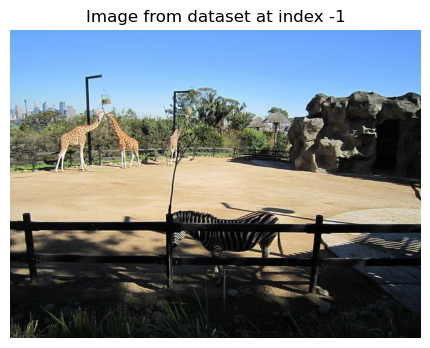

In [13]:
# Convert bytes to image using PIL
image_bytes = dataset['shots']['inputs'][IND]['image']['bytes']

# Create a BytesIO object from the bytes
image_stream = io.BytesIO(image_bytes)

# Open the image using PIL
pil_image = Image.open(image_stream)

# We can also resize an image in case of limited GPU RAM
#pil_image = pil_image.resize((512, 512)).convert("RGB")

# Convert PIL image to numpy array for matplotlib
image_array = np.array(pil_image)

# Display the image
plt.figure(figsize=(6, 4))
plt.imshow(image_array)
plt.axis('off')  # Hide axes
plt.title(f"Image from dataset at index {IND}")
plt.show()

In [14]:
print('Instruction:', dataset['shots']['instruction'][IND],
      '\n\nQuestion:', dataset['shots']['inputs'][IND]['question'], '\n', ## question from dict
      '\nOutputs:', dataset['shots']['outputs'][IND], 
      '\nMeta:', dataset['shots']['meta'][IND]
     )

Instruction: Тебе даны изображение <image> и вопрос к этому изображению. Ответь на заданный вопрос кратко, без воды, в той форме, как спрашивается в вопросе, цифрой, если ответ число.

Вопрос:{question}
Ответ: 

Question: Как называется чёрно-белое животное на фото, которое стоит возле забора? 
 
Outputs: Зебра 
Meta: {'id': 50, 'categories': {'question_type': 'how'}, 'image': {'source': 'photo'}, 'complexity': 'complex_question'}


In [15]:
instruction = dataset['shots']['instruction'][IND]
instruction

'Тебе даны изображение <image> и вопрос к этому изображению. Ответь на заданный вопрос кратко, без воды, в той форме, как спрашивается в вопросе, цифрой, если ответ число.\n\nВопрос:{question}\nОтвет:'

In [16]:
question = dataset['shots']['inputs'][IND]['question']
question

'Как называется чёрно-белое животное на фото, которое стоит возле забора?'

Объединим инструкцию и вопрос по изображению в единый запрос, который будем передавать на вход модели через chat_template

In [18]:
query = instruction.replace("{question}", ' ' + question)
print(query)

Тебе даны изображение <image> и вопрос к этому изображению. Ответь на заданный вопрос кратко, без воды, в той форме, как спрашивается в вопросе, цифрой, если ответ число.

Вопрос: Как называется чёрно-белое животное на фото, которое стоит возле забора?
Ответ:


## 2. Выбор и загрузка модели

- Выберите инструктивную мультимодальную модель, работающую с изображениями и русским языком.

Рекомендуется: Qwen/Qwen2-VL-2B-Instruct — компактная, но подходящая для задачи.

- Поднимите модель с помощью transformers .
- Проверьте, что модель корректно отвечает на одиночный тестовый пример.

In [20]:
base_model = "Qwen/Qwen2-VL-2B-Instruct"

In [21]:
min_pixels = 224*224
max_pixels = 1024*1024

processor = AutoProcessor.from_pretrained(base_model, min_pixels=min_pixels, max_pixels=max_pixels) #for memory optimization

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [22]:
# Loading our model on the available device
model = Qwen2VLForConditionalGeneration.from_pretrained(base_model, device_map="auto")
model.device

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

device(type='cuda', index=0)

Подготовим chat_template 

In [24]:
conversation = [
    {
        "role":"user",
        "content":[
            {
                "type":"image",
                "image": pil_image
            },
            {
                "type":"text",
                "text": query #"Опиши изображение."
            }
        ]
    }
]

Применим chat_template к входным данным

In [26]:
inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device)

In [27]:
# Inference: Generation of the output
output_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
print(output_text[0])

Зебра


In [28]:
assert output_text[0].lower() == dataset['shots']['outputs'][IND].lower()

Сгенерированный моделью ответ в точности совпадает с референсным в наборе данных !

## 3. Прогон датасета

- Придумайте и зафиксируйте промпт для вашей задачи (можно взять готовый из описания датасета и адаптировать).
- Прогоните модель на сэмпле теста, собрав ответы.

Примечание: в случае возникновения ошибки OUT OF MEMORY – предварительно уменьшите разрешение картинок.

- При необходимости выполните постобработку (удаление лишнего текста, приведение регистра и т.д.).

In [31]:
dataset

DatasetDict({
    shots: Dataset({
        features: ['instruction', 'inputs', 'outputs', 'meta'],
        num_rows: 10
    })
    test: Dataset({
        features: ['instruction', 'inputs', 'outputs', 'meta'],
        num_rows: 2922
    })
})

In [32]:
random.seed(42)
start_range = 0
end_range = len(dataset['test'])
num_unique_integers = 10  ## just 10 samples to start with...

# Generate a list of 5 unique random integers between 1 and 100 (inclusive)
unique_random_list = random.sample(range(start_range, end_range + 1), num_unique_integers)

print(unique_random_list)

[2619, 456, 102, 1126, 1003, 914, 571, 419, 2771, 2233]


In [33]:
data_sample = dataset['test'].select(unique_random_list)
data_sample

Dataset({
    features: ['instruction', 'inputs', 'outputs', 'meta'],
    num_rows: 10
})

In [34]:
IND = -1

In [35]:
print('Instruction:', data_sample['instruction'][IND],
      '\n\nQuestion:', data_sample['inputs'][IND]['question'], '\n', ## question from dict
      '\nOutputs:', data_sample['outputs'][IND], 
      '\nMeta:', data_sample['meta'][IND]
     )

Instruction: Тебе дали следующую картинку <image>.
Ответь на вопрос по картинке как можно кратко, ничего не дописывая. Приводить ответ к начальной форме не нужно, числа пишем цифрой.

Вопрос:{question}
Ответ: 

Question: Какого цвета футболка у мужчины, который стоит на коленях? 
 
Outputs: Красного 
Meta: {'id': 2243, 'categories': {'question_type': 'which'}, 'image': {'source': 'photo'}, 'complexity': 'simple_question'}


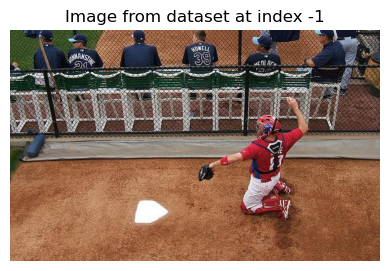

In [36]:
# Convert bytes to image using PIL
image_bytes = data_sample['inputs'][IND]['image']['bytes']

# Create a BytesIO object from the bytes
image_stream = io.BytesIO(image_bytes)

# Open the image using PIL
pil_image = Image.open(image_stream)

# Convert PIL image to numpy array for matplotlib
image_array = np.array(pil_image)

# Display the image
plt.figure(figsize=(5, 3))
plt.imshow(image_array)
plt.axis('off')  # Hide axes
plt.title(f"Image from dataset at index {IND}")
plt.show()

In [37]:
# Let's write info function to get familiar with sample dataset
def know_your_dataset(data_set):
    for i, row in enumerate(data_set):
        print('\n=== indice =', i, '==='
              '\nInstruction:', data_set['instruction'][i],
              '\n\nQuestion:', data_set['inputs'][i]['question'], '\n', ## question from dict
              '\nOutputs:', data_set['outputs'][i], 
              '\nMeta:', data_set['meta'][i]
              )
        # Plotting image 
        image_bytes = data_set['inputs'][i]['image']['bytes']
        image_stream = io.BytesIO(image_bytes)
        image = Image.open(image_stream)
        image_array = np.array(image)
        # Display the image
        plt.figure(figsize=(5, 3))
        plt.imshow(image_array)
        plt.axis('off')  # Hide axes
        plt.title(f"Image from dataset at index {i}")
        plt.show()

In [38]:
#know_your_dataset(data_sample)

In [39]:
# helper function to prepare list of conversations for batch inference
def make_conversations_list(data_set, verbose=False):
    conversations_list = []
    for i, row in enumerate(data_set):
        #Preparing qruery for chat_template
        instruction = data_set['instruction'][i]
        question = data_set['inputs'][i]['question']
        query = instruction.replace("{question}", ' ' + question)
        if verbose:
            print(query)

        # Getting image from dataset
        image_bytes = data_set['inputs'][i]['image']['bytes']
        image_stream = io.BytesIO(image_bytes)
        image = Image.open(image_stream)

        # Display the image
        if verbose:
            image_array = np.array(image)
            plt.figure(figsize=(5, 3))
            plt.imshow(image_array)
            plt.axis('off')  # Hide axes
            plt.title(f"Image from dataset at index {i}")
            plt.show()
        
        conversation = [
            {
                "role":"user",
                "content":[
                    {
                        "type":"image",
                        "image": image
                    },
                    {
                        "type":"text",
                        "text": query 
                    }
                ]
            }
        ]
        conversations_list.append(conversation)
    return conversations_list    

Тебе даны изображение <image> и вопрос к этому изображению. Ответь на заданный вопрос кратко, без воды, в той форме, как спрашивается в вопросе, цифрой, если ответ число.

Вопрос: Ноутбук является продуктом компании Apple?
Ответ:


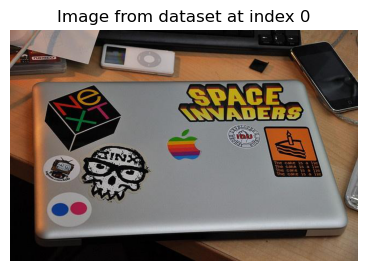

Перед тобой фото, либо изображение <image>.
К нему дается вопрос. Ответь на этот вопрос кратко, ничего не дописывая кроме самого ответа. Ответ пиши не в начальной форме, а так как спрашивается в вопросе, в случае чисел — ответ пиши цифрой.

Вопрос: Собака на картинке бойцовской породы?
Ответ:


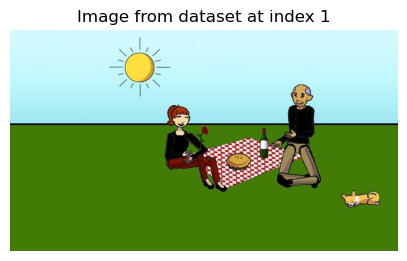

Вам дана картинка: <image>.
Ответьте на вопрос, заданный по этой картинке. Ответ напишите краткий, в той форме, которая задается вопросом, если это число, то напишите его цифрой, а не текстом.

Вопрос: Что написано на фото?
Ответ:


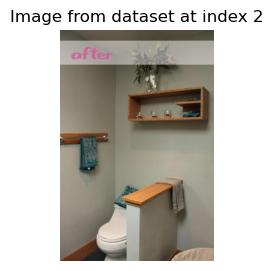

Перед тобой фото, либо изображение <image>.
К нему дается вопрос. Ответь на этот вопрос кратко, ничего не дописывая кроме самого ответа. Ответ пиши не в начальной форме, а так как спрашивается в вопросе, в случае чисел — ответ пиши цифрой.

Вопрос: На фото есть люди?
Ответ:


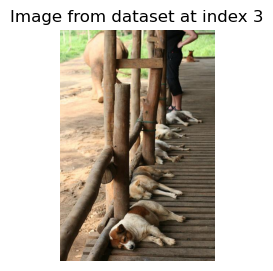

Тебе дали следующую картинку <image>.
Ответь на вопрос по картинке как можно кратко, ничего не дописывая. Приводить ответ к начальной форме не нужно, числа пишем цифрой.

Вопрос: Человек какого пола на фото?
Ответ:


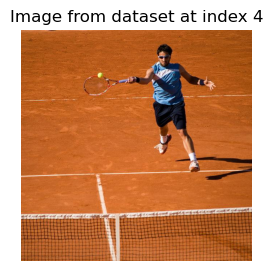

Перед Вами картинка или фото: <image> и вопрос. Ответьте на вопрос по изображению.
Вопрос: Какая погода на фото?
Ответ должен быть написан кратко, в той же форме, которую предполагает вопрос. Если ответом является число, напишите его цифрой.

Ответ:


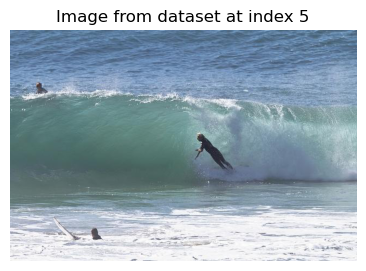

<image> Посмотрите на предложенное изображение.
Ответьте на заданный вопрос кратким ответом (числа пиши не текстом, а цифрой), не рассуждая.

Вопрос: Сколько ноздрей у Зебры?



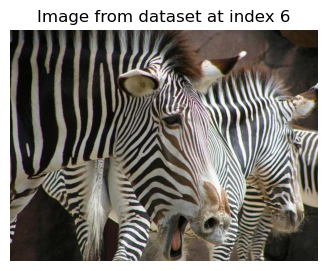

Тебе даны изображение <image> и вопрос к этому изображению. Ответь на заданный вопрос кратко, без воды, в той форме, как спрашивается в вопросе, цифрой, если ответ число.

Вопрос: Какого цвета потолок в помещении?
Ответ:


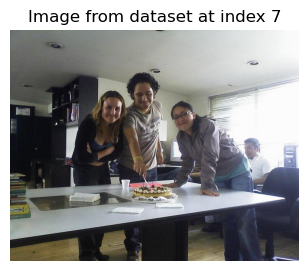

<image> Посмотрите на предложенное изображение.
Ответьте на заданный вопрос кратким ответом (числа пиши не текстом, а цифрой), не рассуждая.

Вопрос: Какого цвета джинсы у прыгающего человека?



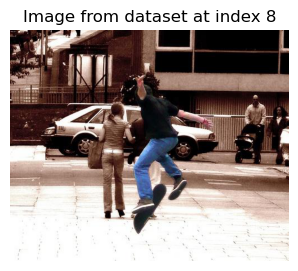

Тебе дали следующую картинку <image>.
Ответь на вопрос по картинке как можно кратко, ничего не дописывая. Приводить ответ к начальной форме не нужно, числа пишем цифрой.

Вопрос: Какого цвета футболка у мужчины, который стоит на коленях?
Ответ:


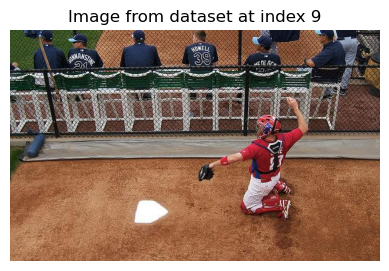

In [40]:
conversations = []
conversations = make_conversations_list(data_sample, verbose=True)

In [41]:
#conversations

In [42]:
#conversations = [conversation1, conversation2, conversation3, conversation4]
# Preparation for batch inference
inputs = processor.apply_chat_template(
    conversations,
    #fps=1,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
    truncation=True,
    padding=True,
).to(model.device)

In [43]:
# Batch Inference
output_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
print(output_text)

['Да, ноутбук является продуктом компании Apple.', '0', '1', 'Нет', 'Мужской', 'Солнечно', '2', 'Белый', 'Синий', 'Синий']


In [44]:
list(zip(output_text, data_sample['outputs']))

[('Да, ноутбук является продуктом компании Apple.', 'Да'),
 ('0', 'Нет'),
 ('1', 'after'),
 ('Нет', 'Да'),
 ('Мужской', 'Мужского'),
 ('Солнечно', 'Солнечная'),
 ('2', '2'),
 ('Белый', 'Белого'),
 ('Синий', 'Синие'),
 ('Синий', 'Красного')]

Видим, что ответы модели достаточно близки к референсным, но в точности совпадают только в одном (#7) случае.

## 4. Оценка качества

- Реализуйте метрику Exact Match (строгое совпадение предсказанного и реального ответа).
- Посчитайте качество модели на вашем тестовом сэмпле.

In [47]:
def exact_match(pred_labels, true_labels):
    res = sum([lp.lower() == lt.lower() for lp, lt in zip(pred_labels, true_labels)])/len(pred_labels)
    print(f'exact_match: {res}')
    return res 

In [48]:
exact_match(output_text, data_sample['outputs'])

exact_match: 0.1


0.1

Метрика exact_match для отдельного элемента из набора данных равна 1 в случае точного совпадения и 0, во всех остальных случаях. На нашем мини сэмпле из 10 элементов exact_match составляет всего 10%, хотя ответы модели корректны и близки к референсным в 6 случаях из 10. То есть, из метрики непонятно, насколько модель близка к правильному ответу.

Реализуем альтернативную метрику almost_match, которая будет равна 1, если ответ достаточно близок к референсному. Ниже наивная реализация, сравнивающая первые N (параметр threshold) символов ответа и дающая дополнительное представление о том, насколько ответы модели близки к референсным.

In [50]:
def almost_match(pred_labels, true_labels, threshold=3):
    # function to check if N first characters match 
    def n_first_match(str_pred, str_true, threshold=3):
        """
        In: two strings, prediction and reference;
            threshold: level of tolerance, defines the N first characters to compare;
        Out: returns True if N=threshold first characters are the same and False otherwise;
        """
        n = len(str_true) if len(str_true) < threshold else threshold
        return str_pred[:n].lower() == str_true[:n].lower()  
    
    res = sum([n_first_match(lp, lt, threshold=threshold) for lp, lt in zip(pred_labels, true_labels)])/len(pred_labels)
    print(f'almost_match: {res}')
    return res

In [51]:
almost_match(output_text, data_sample['outputs'])

almost_match: 0.6


0.6

На сэмпле из 10 элементов, разница между 0.1 и 0.6 драматическая. Предполагаю, что это эффект низкой базы и с увеличением размера датасета, разница между метриками будет сокращаться.

## 4.2 Запустим обработку сэмпла из 200 случайных элементов датасета 

При batch обработке сэмпла с более чем 25 изображениями, процесс падает по out of memory - поэтому обрабатывать 200 изображений будем проверенным способом в цикле по одному ))

In [55]:
random.seed(42)
start_range = 0
end_range = len(dataset['test'])
num_unique_integers = 200  ## number of random elements (indices) in our sample

# Generate a list of unique random integers between 1 and 100 (inclusive)
unique_random_list = random.sample(range(start_range, end_range + 1), num_unique_integers)

print(len(unique_random_list), unique_random_list[:10])

200 [2619, 456, 102, 1126, 1003, 914, 571, 419, 2771, 2233]


In [56]:
data_sample = dataset['test'].select(unique_random_list)
data_sample

Dataset({
    features: ['instruction', 'inputs', 'outputs', 'meta'],
    num_rows: 200
})

In [57]:
output_text_list = []
for item in tqdm(data_sample):

    instruction = item['instruction']
    question = item['inputs']['question']
    query = instruction.replace("{question}", ' ' + question)
    
    image_bytes = item['inputs']['image']['bytes']
    image_stream = io.BytesIO(image_bytes)
    image = Image.open(image_stream)
    
    conversation = [
        {
            "role":"user",
            "content":[
                {
                    "type":"image",
                    "image": image
                },
                {
                    "type":"text",
                    "text": query 
                }
            ]
        }
    ]
    
    inputs = processor.apply_chat_template(
        conversation,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt"
    ).to(model.device)
    
    # Inference: Generation of the output
    output_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    output_text_list.append(output_text[0])

  0%|          | 0/200 [00:00<?, ?it/s]

In [58]:
len(output_text_list), output_text_list[:10]

(200,
 ['Да, ноутбук является продуктом компании Apple.',
  '0',
  '1',
  'Нет',
  'Мужской',
  'Солнечно',
  '2',
  'Белый',
  'Синий',
  'Синий'])

In [59]:
# Dict to store metrics
results = {}

In [60]:
results['dataset prompt'] = [exact_match(output_text_list, data_sample['outputs']), almost_match(output_text_list, data_sample['outputs'])]

exact_match: 0.23
almost_match: 0.38


In [61]:
pd.DataFrame(results, index=['exact_match','almost_match']).T

,exact_match,almost_match
dataset prompt,0.23,0.38


## 5. Эксперименты с промптами

- Придумайте 2–3 промпта на русском и 2–3 промпта на английском.
- Для каждого промпта прогоните тестовую выборку.
- Сравните качество (Exact Match) между промптами.

В выбранном наборе данных различные изображения предполагают различные вопросы, для получения ожидаемых ответов. Промпты (инструкции) и вопросы уже содержатся в наборе данных, поэтому формирование промпта в первом прогоне было динамическим для каждого элемента. Поэтому, с учетом специфики набора данных и требования в задании использовать английский промпт, сравнивать буду 3 подхода:
1. Динамический промпт + вопрос из набора данных (все на русском);
2. Статичный промпт + вопрос из набора данных (все на русском);
3. Статичный промпт (на английском) + вопрос из набора данных (на русском);
В третьем варианте, чтобы не путать модель, и вопросы следует перевести на английский, но это упражнение выходит за рамки домашнего задания ) Предполагаю, что из-за смеси языков, модель будет путаться и результаты будут наихудшими. 

### 5.1 Статичный промпт на русском

In [65]:
ru_prompt = "Тебе даны изображение <image> и вопрос к этому изображению. Ответь на заданный вопрос кратко, без воды, в той форме, как спрашивается в вопросе, цифрой, если ответ число.\n\nВопрос:{question}\nОтвет:"

In [66]:
output_text_list = []
for item in tqdm(data_sample):

    instruction = ru_prompt
    question = item['inputs']['question']
    query = instruction.replace("{question}", ' ' + question)
    
    image_bytes = item['inputs']['image']['bytes']
    image_stream = io.BytesIO(image_bytes)
    image = Image.open(image_stream)
    
    conversation = [
        {
            "role":"user",
            "content":[
                {
                    "type":"image",
                    "image": image
                },
                {
                    "type":"text",
                    "text": query 
                }
            ]
        }
    ]
    
    inputs = processor.apply_chat_template(
        conversation,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt"
    ).to(model.device)
    
    # Inference: Generation of the output
    output_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    output_text_list.append(output_text[0])

  0%|          | 0/200 [00:00<?, ?it/s]

In [67]:
len(output_text_list), output_text_list[:10]

(200,
 ['Да, ноутбук является продуктом компании Apple.',
  '0',
  '"after"',
  'Да, есть люди.',
  'Мужской',
  'Солнечно',
  '3',
  'Белый',
  'Синий',
  'Черный'])

In [68]:
results['ru static prompt'] = [exact_match(output_text_list, data_sample['outputs']), almost_match(output_text_list, data_sample['outputs'])]

exact_match: 0.185
almost_match: 0.48


In [69]:
pd.DataFrame(results, index=['exact_match','almost_match']).T

,exact_match,almost_match
dataset prompt,0.230,0.38
ru static prompt,0.185,0.48


### 5.2 Статичный английский промпт

In [71]:
en_prompt = "You are given an image <image> and a question about it. Answer the question briefly, without further ado, in the form asked in the question, using a number if the answer is a number. Provide your answer in Russian. \n\nQuestion: {question}\nAnswer:"

In [72]:
output_text_list = []
for item in tqdm(data_sample):

    instruction = en_prompt
    question = item['inputs']['question']
    query = instruction.replace("{question}", ' ' + question)
    
    image_bytes = item['inputs']['image']['bytes']
    image_stream = io.BytesIO(image_bytes)
    image = Image.open(image_stream)
    
    conversation = [
        {
            "role":"user",
            "content":[
                {
                    "type":"image",
                    "image": image
                },
                {
                    "type":"text",
                    "text": query 
                }
            ]
        }
    ]
    
    inputs = processor.apply_chat_template(
        conversation,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt"
    ).to(model.device)
    
    # Inference: Generation of the output
    output_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    output_text_list.append(output_text[0])

  0%|          | 0/200 [00:00<?, ?it/s]

In [73]:
len(output_text_list), output_text_list[:10]

(200,
 ['No',
  '1',
  'after',
  '0',
  'Мужской',
  'Солнечно',
  '2',
  'Белый',
  'Синий',
  'Синий'])

In [74]:
results['en static prompt'] = [exact_match(output_text_list, data_sample['outputs']), almost_match(output_text_list, data_sample['outputs'])]

exact_match: 0.11
almost_match: 0.18


## 6. Анализ и выводы

Итоговые результаты

In [145]:
pd.DataFrame(results, index=['exact_match','almost_match']).T.sort_values(by='exact_match', ascending=False)

,exact_match,almost_match
dataset prompt,0.230,0.38
ru static prompt,0.185,0.48
en static prompt,0.110,0.18


- Вариант с динамичным формированием промпта по инструкции и вопросу из датасета ожидаемо показывает наилучший результат, поскольку референсная модель тестировалась именно в таких условиях;
- Статичный "универсальный" промпт на русском показал снижение метрики exact_match, но увеличение части "почти" правильных ответов. Предполагаю, что в отсутствии референсного промпта, часть ответов из в точности совпадающих переместилась в почти совпадающие;
- Ожидаемо худшие результаты получены на миксе английского промпта и вопроса на русском. Но при этом, модель точно ответила на вопрос по третьему изображению, где спрашивается, что написано на изображении и надпись сделана на английском. Модель корректно ответила "after", а в первом варианте ошиблась.

Общие выводы:
- Даже небольшая модель неплохо справляется с обработкой изображений и ответами на достаточно сложные вопросы, включая способность "читать" надписи );
- Для улучшения результатов имеет смысл использовать модель с большим количеством параметров;
- В промпт инжиниринге есть часть от инжиниринга, а остальное искусство... )